In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import sys
import time
import re
from process_reuters import begin
from datatypes import KEY_POSITIONS,SHIFT_WIDTH,SPACE_WIDTH,KEY_HEIGHT,COMMAND_WIDTH,CAPSLOCK_WIDTH,KEY_WIDTH,ROW_HEIGHT,ENTER_WIDTH,BACKSPACE_WIDTH,TAB_WIDTH,MODIFIER_KEYS,ALL_USED_KEYS,KEYBOARD_WIDTH,KEYBOARD_HEIGHT,DEFAULT_TRANSLATION,itos,stoi,MODIFIER_KEY_MAP,SHIFT_KEY_MAP
from utils import calculate_distance_matrix,timeit,filter_keylogs,parse_python,parse_keys,keyboard_cost

In [8]:
distance_matrix = calculate_distance_matrix(KEY_POSITIONS)
print(distance_matrix[('-','[')])

83.24061508662703


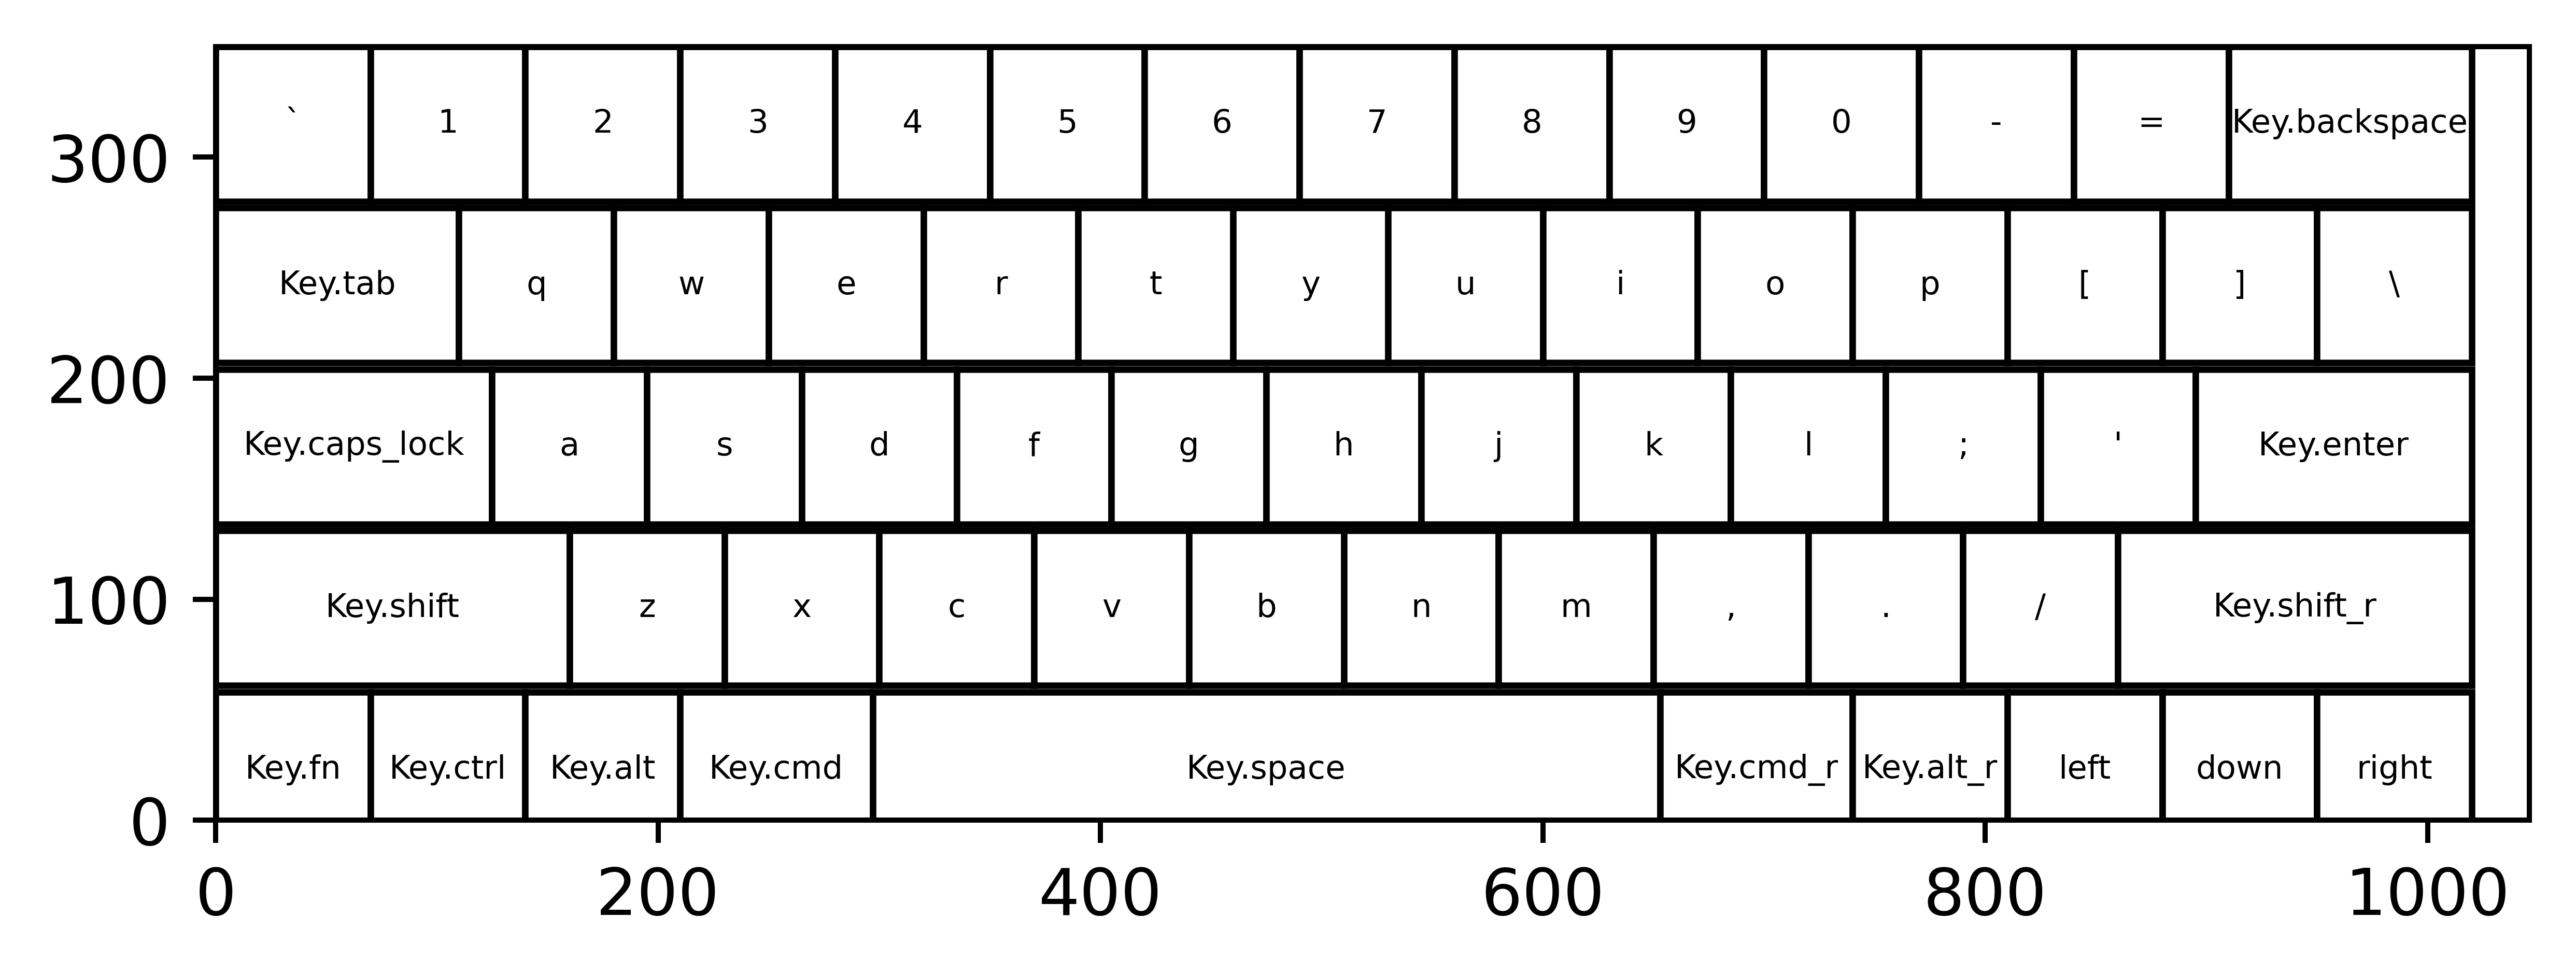

In [9]:
# plot the keyboard layout with names of the keys in matplotlib
# take into account that different keys have different widths

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_keyboard(translation_dictionary):
    fig,ax = plt.subplots(1,dpi=900)

    for key in KEY_POSITIONS:
        # if key.startswith('Key'):
        #     print(key,key in translation_dictionary)
        if key in translation_dictionary:
            translated_key = translation_dictionary[key]
            key_position = KEY_POSITIONS[translated_key]
            if translated_key == 'Key.space':
                rect = patches.Rectangle((key_position[0] - SPACE_WIDTH * 0.5,key_position[1] - KEY_HEIGHT*0.5),SPACE_WIDTH,ROW_HEIGHT,linewidth=1,edgecolor='k',facecolor='w')
            elif key in ['Key.shift','Key.shift_r']:
                rect = patches.Rectangle((KEY_POSITIONS[key][0] - SHIFT_WIDTH * 0.5,KEY_POSITIONS[key][1] - KEY_HEIGHT*0.5),SHIFT_WIDTH,ROW_HEIGHT,linewidth=1,edgecolor='k',facecolor='w')
            elif key in ['Key.cmd','Key.cmd_r']:
                rect = patches.Rectangle((KEY_POSITIONS[key][0] - COMMAND_WIDTH * 0.5,KEY_POSITIONS[key][1] - KEY_HEIGHT*0.5),COMMAND_WIDTH,ROW_HEIGHT,linewidth=1,edgecolor='k',facecolor='w')
            elif key in ['Key.caps_lock','Key.enter']:
                rect = patches.Rectangle((KEY_POSITIONS[key][0] - CAPSLOCK_WIDTH * 0.5,KEY_POSITIONS[key][1] - KEY_HEIGHT*0.5),ENTER_WIDTH,ROW_HEIGHT,linewidth=1,edgecolor='k',facecolor='w')
            elif key in ['Key.tab','Key.backspace']:
                rect = patches.Rectangle((KEY_POSITIONS[key][0] - TAB_WIDTH * 0.5,KEY_POSITIONS[key][1] - KEY_HEIGHT*0.5),BACKSPACE_WIDTH,ROW_HEIGHT,linewidth=1,edgecolor='k',facecolor='w')
            else:
                rect = patches.Rectangle((key_position[0] - KEY_WIDTH * 0.5,key_position[1] - KEY_HEIGHT*0.5),KEY_WIDTH,ROW_HEIGHT,linewidth=1,edgecolor='k',facecolor='w')
            ax.text(key_position[0],key_position[1],key,fontsize=5,ha='center',va='center')
        else:
            rect = patches.Rectangle((KEY_POSITIONS[key][0] - KEY_WIDTH * 0.5,KEY_POSITIONS[key][1] - KEY_HEIGHT*0.5),KEY_WIDTH,ROW_HEIGHT,linewidth=1,edgecolor='k',facecolor='w')
            ax.text(KEY_POSITIONS[key][0],KEY_POSITIONS[key][1],key,fontsize=5,ha='center',va='center')
        ax.add_patch(rect)

    ax.set_xlim(0,KEYBOARD_WIDTH)
    ax.set_ylim(0,KEYBOARD_HEIGHT)
    ax.set_aspect('equal')
    plt.show()

display_keyboard(DEFAULT_TRANSLATION)

In [10]:
print('fn',
KEY_POSITIONS['fn'],
KEY_POSITIONS['left_control'],
KEY_POSITIONS['left_option'],
KEY_POSITIONS['left_command'],
KEY_POSITIONS[' '],
KEY_POSITIONS['right_command'],
KEY_POSITIONS['right_option'],
KEY_POSITIONS['left'],
KEY_POSITIONS['down'],
KEY_POSITIONS['right'])

# X positions should be increasing left to right

KeyError: 'fn'

In [11]:
test_phrase = 'the quick brown fox jumps over the lazy dog'

# calculate the cost of a keyboard layout
# finger travel distance is the sum of the distances between each pair of letters in the test phrase
# the cost is the sum of the distances between each pair of letters in the test phrase
# each finger has a few keys that it can reach easily

finger_keys = {
    'left_pinky': ['q','a','z','1','`','tab','capslock','left_shift'],
    'left_ring': ['w','s','x','2'],
    'left_middle': ['e','d','c','3'],
    'left_index': ['r','f','v','t','g','b','6','5','4'],
    'left_thumb': ['left_command'],
    'right_thumb': [' '],
    'right_index': ['y','h','n','u','j','m','7','8'],
    'right_middle': ['i','k',',','9'],
    'right_ring': ['l','o','.','0'],
    'right_pinky': [';','p','/','-','=','[',']','\\','\''],
}

home_finger_positions = {
    'left_pinky': 'a',
    'left_ring': 's',
    'left_middle': 'd',
    'left_index': 'f',
    'left_thumb': 'left_command',
    'right_thumb': ' ',
    'right_index': 'j',
    'right_middle': 'k',
    'right_ring': 'l',
    'right_pinky': ';',
}

keys_by_finger = {}
for finger in finger_keys:
    for key in finger_keys[finger]:
        keys_by_finger[key] = finger

series_by_finger = pd.Series(keys_by_finger)
series_by_home_finger = pd.Series(home_finger_positions)
series_by_distance = pd.Series({k[0]+k[1]:v for k,v in distance_matrix.items()})


In [6]:
# technically its faster if the fingers alternate as opposed to repeat. so the cost should be higher if the same finger is used twice in a row
from functools import cache

def keyboard_cost(text,distance_matrix,translation_dictionary):
    cost = 0
    previous_finger = None
    previous_letter = None
    translated_letters = [translation_dictionary[letter] for letter in text]
    for letter in translated_letters:
        finger = keys_by_finger[letter]
        if finger != previous_finger:
            finger_position = home_finger_positions[finger]
            cost += distance_matrix[(letter,finger_position)]
            previous_finger = finger
        else:
            cost += distance_matrix[(previous_letter,letter)] * 1.5
        previous_letter = letter
    return cost / KEY_WIDTH / len(text)# normalized by key width and text length

layout_cost = keyboard_cost(test_phrase,distance_matrix,DEFAULT_TRANSLATION)
print('qwerty keyboard cost',layout_cost)

KeyError: ' '

In [ ]:
a = np.array([False,False,True,False,True])
b = np.where(a == True)[0] - 1
print(b)

[1 3]


In [12]:
def randomly_permute_keyboard():
    result = np.random.choice(ALL_USED_KEYS, size=len(ALL_USED_KEYS), replace=False)
    translation_dictionary = {k:v for k,v in zip(result,ALL_USED_KEYS)}
    return translation_dictionary

new_keyboard_dict = randomly_permute_keyboard()
print(new_keyboard_dict)


# get the cost of a new keyboard layout
cost = keyboard_cost(test_phrase,distance_matrix,new_keyboard_dict)
print(cost)

display_keyboard(new_keyboard_dict)

{'1': '`', 'g': '1', '7': '2', ';': '3', 'l': '4', '/': '5', '5': '6', 'b': '7', 'j': '8', 'm': '9', 'a': '0', 't': '-', '6': '=', 'u': 'q', 'i': 'w', 'w': 'e', 'n': 'r', 'o': 't', '`': 'y', 'v': 'u', 's': 'i', 'q': 'o', '=': 'p', '-': '[', 'z': ']', 'p': '\\', '9': 'a', '3': 's', '0': 'd', 'd': 'f', 'k': 'g', 'c': 'h', '[': 'j', "'": 'k', 'f': 'l', '\\': ';', '2': "'", 'y': 'z', 'e': 'x', 'r': 'c', '8': 'v', '.': 'b', 'h': 'n', 'x': 'm', ',': ',', ']': '.', '4': '/'}


NameError: name 'keyboard_cost' is not defined

# Parse data for genetic keyboards

In [11]:
with open('../reuters.txt','r') as f:
    text = f.read()
text = re.sub('\\n', '',text)
number_of_letters = len(text)
print('number of letters',number_of_letters)

FileNotFoundError: [Errno 2] No such file or directory: 'reuters.txt'

# Parse python data for genetic keyboards

using all the mastery python files.

In [16]:
test_data = parse_python()
print([l for l in test_data[:200]])

number of letters 15996741
['i', 'm', 'p', 'o', 'r', 't', ' ', 'o', 's', 'i', 'm', 'p', 'o', 'r', 't', ' ', 's', 'y', 's', 'r', 'o', 'o', 't', 'd', 'i', 'r', ' ', '=', ' ', 's', 'y', 's', '.', 'a', 'r', 'g', 'v', '[', '1', ']', 'i', 'n', 'o', ' ', '=', ' ', '{', '}', 'b', 'u', 'f', ' ', '=', ' ', '[', ']', 'f', 'o', 'r', ' ', 'r', 'o', 'o', 't', ',', ' ', 's', 'u', 'b', 'F', 'o', 'l', 'd', 'e', 'r', 's', ',', ' ', 'f', 'i', 'l', 'e', 's', ' ', 'i', 'n', ' ', 'o', 's', '.', 'w', 'a', 'l', 'k', '(', 'r', 'o', 'o', 't', 'd', 'i', 'r', ')', ':', '\t', 'f', 'o', 'r', ' ', 'f', 'i', 'l', 'e', 'n', 'a', 'm', 'e', ' ', 'i', 'n', ' ', 'f', 'i', 'l', 'e', 's', ':', '\t', '\t', 'f', 'i', 'l', 'e', 'P', 'a', 't', 'h', ' ', '=', ' ', 'o', 's', '.', 'p', 'a', 't', 'h', '.', 'j', 'o', 'i', 'n', '(', 'r', 'o', 'o', 't', ',', ' ', 'f', 'i', 'l', 'e', 'n', 'a', 'm', 'e', ')', '\t', '\t', 't', 'r', 'y', ':', '\t', '\t', '\t', 's', 't', 'a', 't', ' ', '=', ' ', 'o', 's', '.', 'l', 's', 't', 'a', 't', '(',

# Genetic Algorithm for Keyboard Layout Optimization

In [137]:
POPULATION_SIZE = 50
MUTATION_RATE = 0.1
MUTATION_AMOUNT = 0.1
NUM_GENERATIONS = 500
SURVIVAL_RATE = 0.10
PARENT_SELECTION_RATE = 0.20
RANDOM_PORTION = 0.30

def generate_population():
    population = []
    for i in range(POPULATION_SIZE):
        population.append(randomly_permute_keyboard())
    return population

def mutate_keyboard(keyboard):
    new_keyboard = keyboard.copy()
    for key in new_keyboard:
        if np.random.random() < MUTATION_RATE:
            # randomly swap two keys
            key1,key2 = np.random.choice(ALL_USED_KEYS,replace=False,size=2)
            new_keyboard[key1],new_keyboard[key2] = new_keyboard[key2],new_keyboard[key1]
    return new_keyboard

def mutate_population(population):
    new_population = population
    random_keyboards = [randomly_permute_keyboard() for _ in range(int(RANDOM_PORTION * POPULATION_SIZE))]
    for _ in range(int(POPULATION_SIZE * PARENT_SELECTION_RATE)):
        new_population.append(mutate_keyboard(np.random.choice(population)))
    return new_population + random_keyboards

def select_k_best(population):
    costs = [keyboard_cost(text,distance_matrix,keyboard) for keyboard in population]
    # print('costs',costs)
    # select the top 15% of the population
    k = int(len(population) * SURVIVAL_RATE)
    best_indices = np.argsort(costs)[:k]
    # print('best_indices',best_indices)
    return [population[i] for i in best_indices],np.min(costs)

def run_evolution():
    population = generate_population()
    for i in range(NUM_GENERATIONS):
        print('processing {i} of {NUM_GENERATIONS}'.format(i=i,NUM_GENERATIONS=NUM_GENERATIONS))
        k_best,min_cost = select_k_best(population)
        if i % 50 == 0:
            print('generation',i,'min_cost',min_cost)
            display_keyboard(k_best[0])
        population = mutate_population(k_best)
        # break
    return k_best[0]



In [138]:
keyboard_cost(text,distance_matrix,DEFAULT_TRANSLATION)

0.7802798161551813

In [139]:
# vectorized_keyboard_cost(text,distance_matrix,DEFAULT_TRANSLATION)

In [ ]:
best_keyboard = run_evolution()

0.41878714974542014


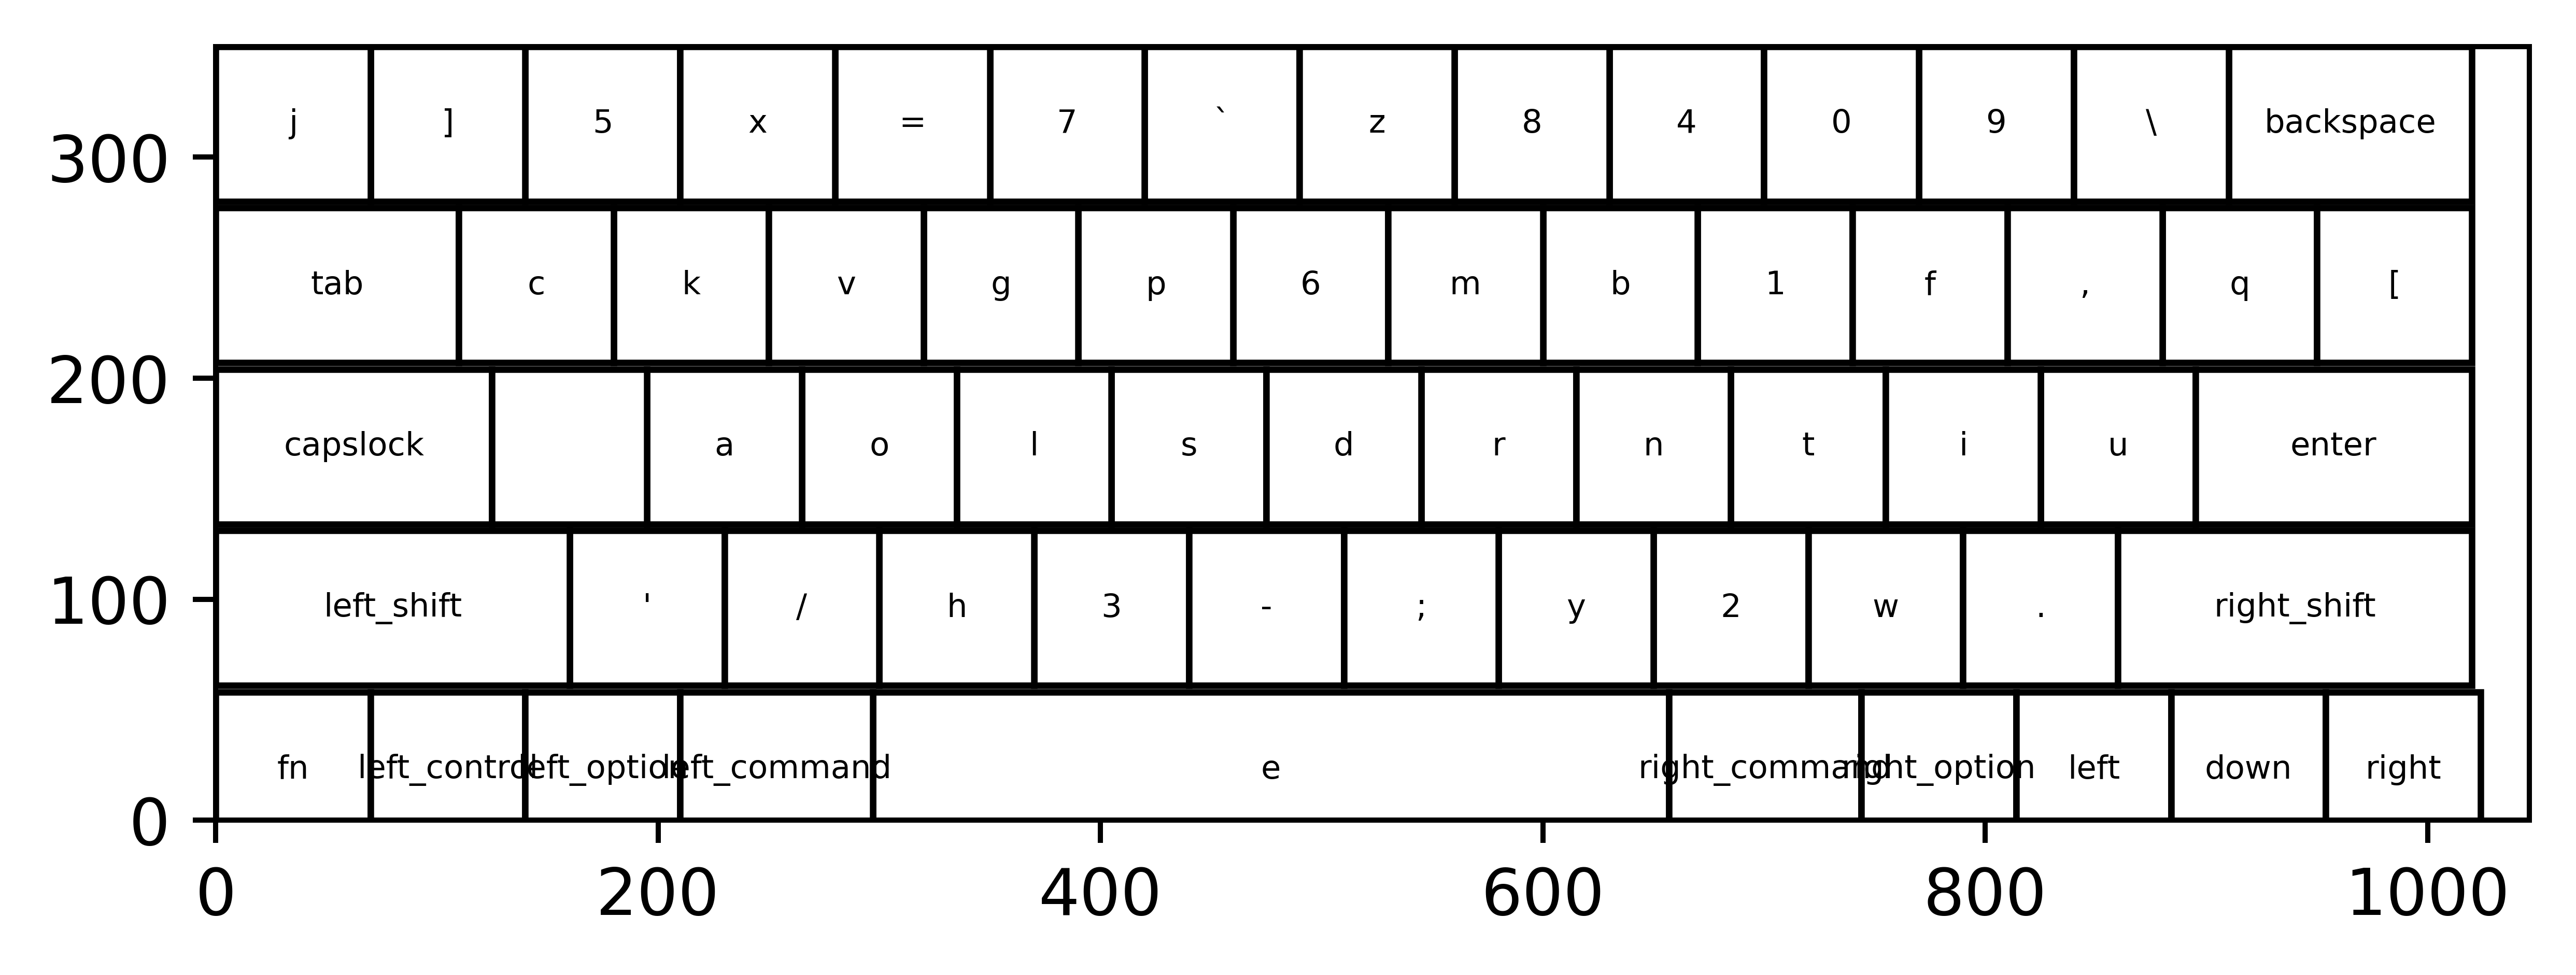

In [142]:

cost = keyboard_cost(text,distance_matrix,best_keyboard)
print(cost)
display_keyboard(best_keyboard)

# Analyzing key logger data

## Initial approach

- digest key logs and measure bigram letter time. The delta between the 1st and 2nd letter should be indicative of how hard it is to go from one to the next. 
- initially i was thinking we'd use a padding variable to account for when you start typing, but it seems difficult to measure how long it takes to hit the first letter.

In [46]:
import datetime

def generate_cost_matrix():
    with open('../keyLog.txt','r') as f:
        key_logs = f.read().splitlines()
    # unique_commands = np.unique([line.split(': ')[1] for line in key_logs])
    # print(unique_commands)

    cost_matrix = np.zeros((len(ALL_USED_KEYS + MODIFIER_KEYS),len(ALL_USED_KEYS + MODIFIER_KEYS)))
    count_matrix = np.ones((len(ALL_USED_KEYS + MODIFIER_KEYS),len(ALL_USED_KEYS + MODIFIER_KEYS)))

    filtered_key_logs = filter_keylogs(key_logs)
    # time_deltas = []
    for line,next_line in zip(filtered_key_logs,filtered_key_logs[1:]):
        # print(line)
        date,command = line
        next_date,next_command = next_line
        # print('date,command',date,command)
        # print('next_date,next_command',next_date,next_command)
        time_delta = datetime.datetime.strptime(next_date,'%Y-%m-%d %H:%M:%S,%f') - datetime.datetime.strptime(date,'%Y-%m-%d %H:%M:%S,%f')
        if time_delta.seconds <= 1:
            cost_matrix[stoi[command],stoi[next_command]] += time_delta.total_seconds()
            count_matrix[stoi[command],stoi[next_command]] += 1
            # time_deltas.append(time_delta)
        # break
    # print(key_logs[:20])
    # print(time_deltas[:25])
    cost_matrix = cost_matrix / count_matrix
    print(itos)
    print(cost_matrix[33,47])
    return cost_matrix

cost_matrix = generate_cost_matrix()

{0: 'Key.enter', 1: 'Key.tab', 2: 'Key.cmd', 3: 'Key.backspace', 4: 'Key.cmd_r', 5: 'Key.ctrl', 6: 'Key.alt', 7: 'Key.alt_r', 8: 'Key.down', 9: 'Key.left', 10: 'Key.right', 11: 'Key.up', 12: 'Key.shift', 13: 'Key.shift_r', 14: 'Key.space', 15: 'Key.caps_lock', 16: 'Key.down', 17: 'Key.left', 18: 'Key.right', 19: 'Key.up', 20: '`', 21: '1', 22: '2', 23: '3', 24: '4', 25: '5', 26: '6', 27: '7', 28: '8', 29: '9', 30: '0', 31: '-', 32: '=', 33: 'q', 34: 'w', 35: 'e', 36: 'r', 37: 't', 38: 'y', 39: 'u', 40: 'i', 41: 'o', 42: 'p', 43: '[', 44: ']', 45: '\\', 46: 'a', 47: 's', 48: 'd', 49: 'f', 50: 'g', 51: 'h', 52: 'j', 53: 'k', 54: 'l', 55: ';', 56: "'", 57: 'z', 58: 'x', 59: 'c', 60: 'v', 61: 'b', 62: 'n', 63: 'm', 64: ',', 65: '.', 66: '/'}
0.1685


In [20]:
res = np.where(cost_matrix == 0)
print(len(res[0]))
res = np.where(cost_matrix > 0)
print(len(res[0]))

0
3969


In [21]:
# create all possible two key combinations and randomly sample from them.

def generate_key_combinations():
    key_combinations = []
    for key1 in ALL_USED_KEYS + MODIFIER_KEYS:
        for key2 in ALL_USED_KEYS + MODIFIER_KEYS:
            key_combinations.append((key1,key2))
    return key_combinations

key_combinations = generate_key_combinations()

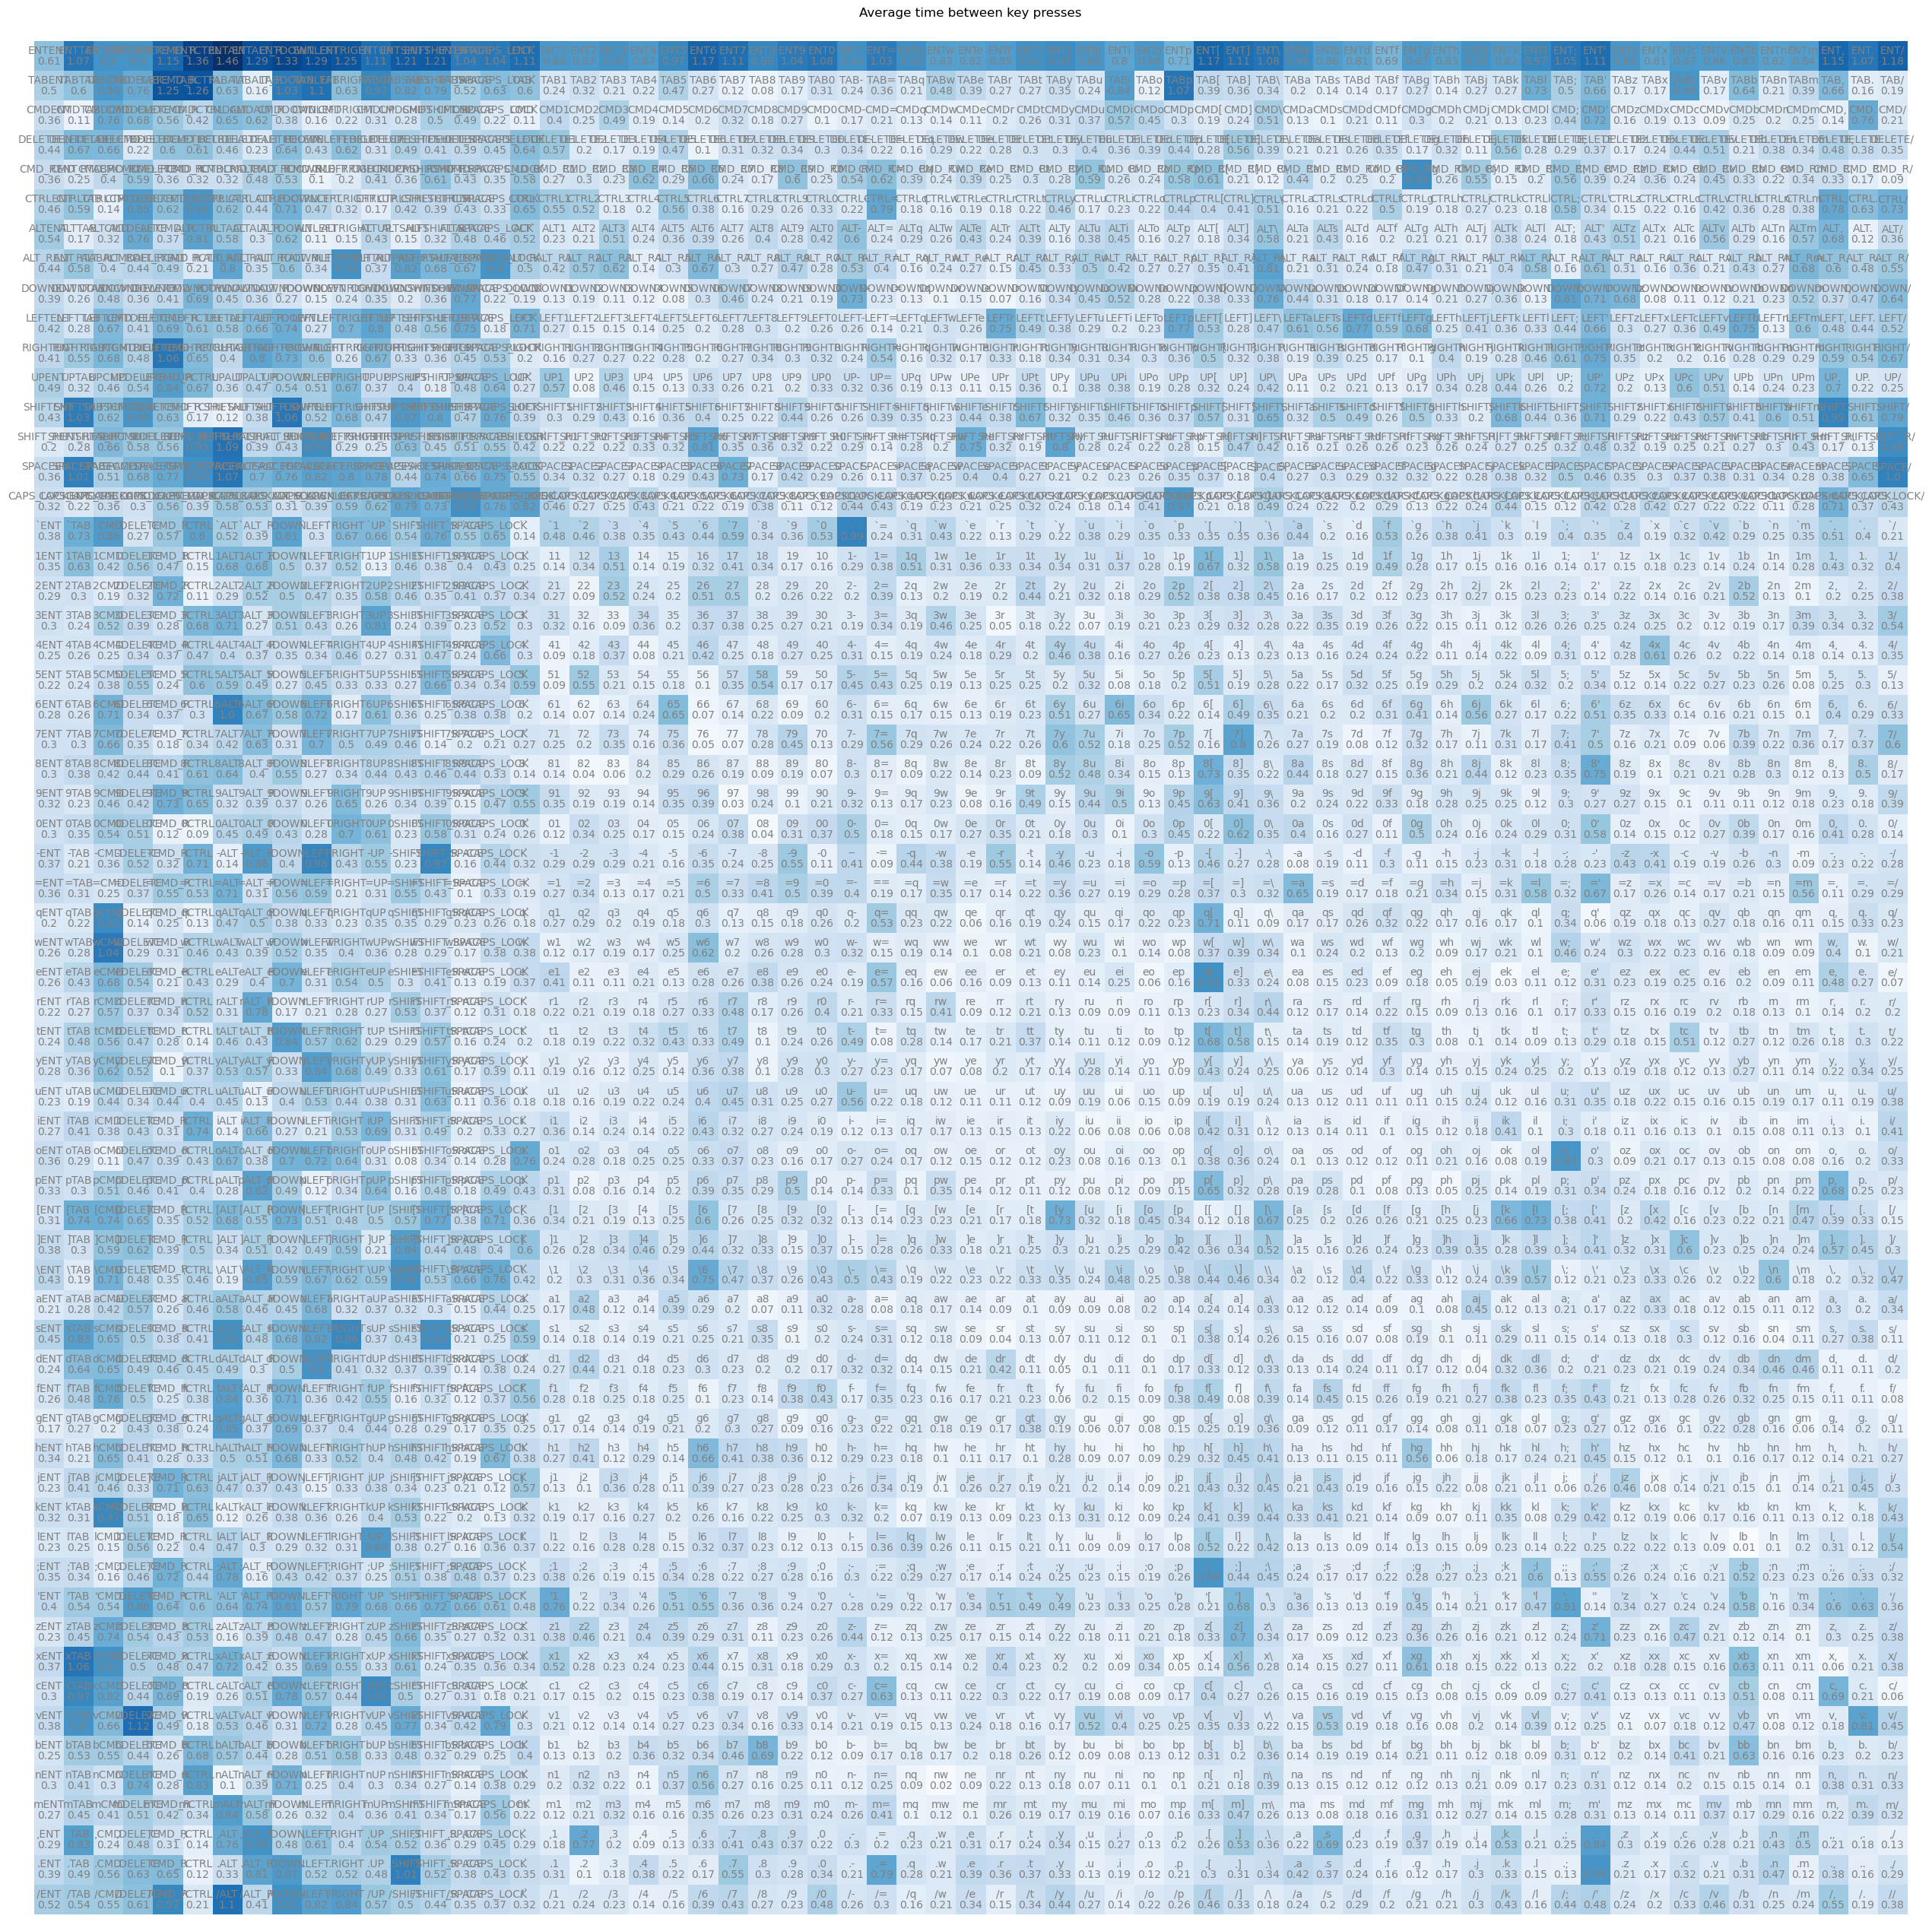

In [22]:
def visualize_keypress_matrix(cost_matrix):
    fig, ax = plt.subplots(figsize=(32,32))
    ax.matshow(cost_matrix,cmap='Blues')
    for (i, j), z in np.ndenumerate(cost_matrix):
        row = MODIFIER_KEY_MAP[itos[i]] if itos[i] in MODIFIER_KEYS else itos[i]
        col = MODIFIER_KEY_MAP[itos[j]] if itos[j] in MODIFIER_KEYS else itos[j]
        chstr = row + col
        ax.text(j,i, chstr, ha='center',va='bottom',color='gray')
        ax.text(j,i, round(cost_matrix[i,j],2), ha='center',va='top',color='gray')
        # ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    ax.set_xlabel('Key pressed')
    ax.set_title('Average time between key presses')
    # ax.set_xticklabels(ALL_USED_KEYS + MODIFIER_KEYS)
    # ax.set_yticklabels(ALL_USED_KEYS + MODIFIER_KEYS)
    plt.axis('off');
    plt.show()
    
visualize_keypress_matrix(cost_matrix)

# extending the training to primary and secondary characters. And modifier keys

In [14]:

def keyboard_cost(text,cost_matrix,translation_dictionary):
    cost = 0
    translated_letters = [translation_dictionary[letter] for letter in text]
    for letter,next_letter in zip(translated_letters,translated_letters[1:]):
        cost += cost_matrix[stoi[letter],stoi[next_letter]]
    return cost / len(text)# normalized by text length


def parse_keys(text):
    keys = []
    for item in text:
        if item in SHIFT_KEY_MAP:
            shift,normal = SHIFT_KEY_MAP[item]
            keys.append(shift)
            keys.append(normal)
        elif item == '\t':
            keys.append('Key.tab')
        elif item == ' ':
            keys.append('Key.space')
        elif item in ALL_USED_KEYS:
            keys.append(item)
    return keys


In [4]:
ord('\'')
chr(39)

"'"

In [2]:
# technically its faster if the fingers alternate as opposed to repeat. so the cost should be higher if the same finger is used twice in a row

test_data = parse_python()
training_data = parse_keys(test_data)
cost_matrix = np.load('assets/cost_matrix.npy')

number of letters 15996741


In [8]:

@timeit
def keyboard_cost2(text,cost_matrix,translation_dictionary):
    return sum([cost_matrix[stoi[translation_dictionary[letter]],stoi[translation_dictionary[next_letter]]] for letter,next_letter in zip(text,text[1:])]) / len(text)# normalized by text length

layout_cost = keyboard_cost(training_data,cost_matrix,DEFAULT_TRANSLATION)
print(keyboard_cost2(training_data,cost_matrix,DEFAULT_TRANSLATION))
print('qwerty keyboard cost',layout_cost)
# print([l for l in training_data[:200]])

'keyboard_cost'  4.98 s
'keyboard_cost2'  4.99 s
0.2600327874801066
qwerty keyboard cost 0.2600327874801066


In [54]:
search = GenericKeyboardSearch(training_data,cost_matrix)

In [ ]:
keyboard = search.run_evolution()

# ML training approach

- use an NN to output the keyboard layout.
- input is the text data
- output is the keyboard layout
- text data must be converted into vectors.
- to compute the cost of the keyboard layout we can matmul the input vectors with the layout matrix.

- input is a stack of vectors. Each vector is a one hot encoding of the character.
- use population based training to train a basket of NNs.

- input is of shape(batch_size, vocab_size)
- output is picking the keyboard layout -> size (vocab_size, vocab_size)
- to construct the keyboard, sample from the output distribution in sequence, and mask the choice from the remaining probability distributions.

## Calculate the cost

the nn output is a probability distribution over the keyboard layout. 

translate the text dataset into the 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# 63 keys
# each vector is length 63

input_nums = [stoi[letter] for letter in training_data]
# output_nums = [stoi[keyboard[letter]] for letter in training_data]

vector_inputs = F.one_hot(torch.tensor(input_nums),num_classes=len(ALL_USED_KEYS + MODIFIER_KEYS))

In [ ]:


# class KeyboardDataset(Dataset):
#     def __init__(self,training_data,cost_matrix):
#         self.training_data = training_data
#         self.cost_matrix = cost_matrix

#     def __len__(self):
#         return len(self.training_data)

#     def __getitem__(self, idx):
#         keyboard = self.training_data[idx]
#         cost = keyboard_cost(self.training_data,self.cost_matrix,keyboard)
#         return keyboard,cost

# dataset = KeyboardDataset(training_data,cost_matrix)

class KeyboardNet(nn.Module):
    def __init__(self):
        super(KeyboardNet, self).__init__()
        self.fc1 = nn.Linear(len(ALL_USED_KEYS + MODIFIER_KEYS), 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, len(ALL_USED_KEYS + MODIFIER_KEYS))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# nn.Sequential(
#     nn.Linear(63, 256),
#     nn.ReLU(),
#     nn.Linear(256, 256),
#     nn.ReLU(),
#     nn.Linear(256, 256),
#     nn.ReLU(),
#     nn.Linear(256, 63),
# )
    


# XML keyboard layout

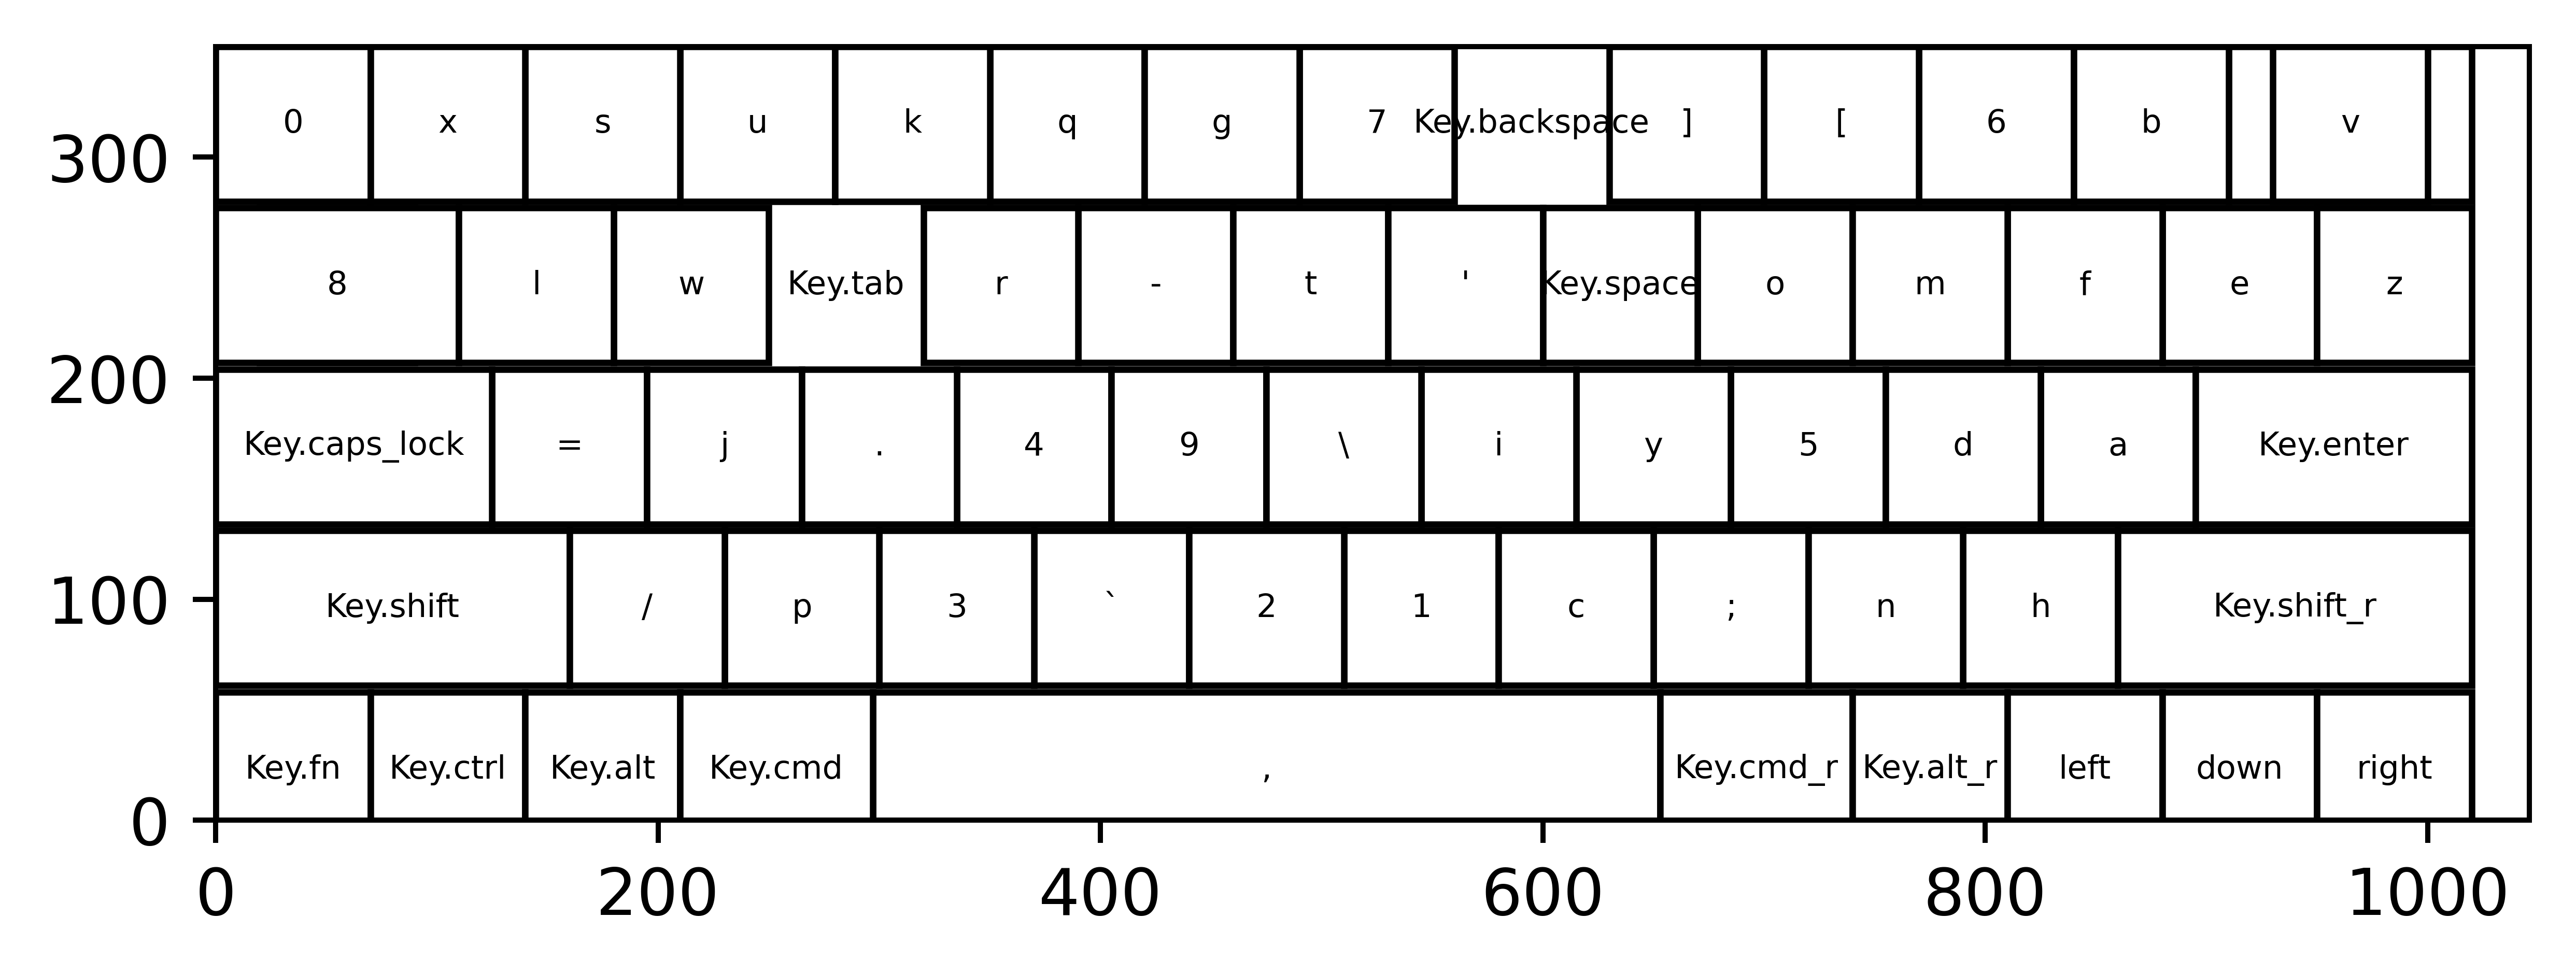

{'0': '`', 'x': '1', 's': '2', 'u': '3', 'k': '4', 'q': '5', 'g': '6', '7': '7', 'Key.backspace': '8', ']': '9', '[': '0', '6': '-', 'b': '=', 'l': 'q', 'w': 'w', 'Key.tab': 'e', 'r': 'r', '-': 't', 't': 'y', "'": 'u', 'Key.space': 'i', 'o': 'o', 'm': 'p', 'f': '[', 'e': ']', 'z': '\\', '=': 'a', 'j': 's', '.': 'd', '4': 'f', '9': 'g', '\\': 'h', 'i': 'j', 'y': 'k', '5': 'l', 'd': ';', 'a': "'", '/': 'z', 'p': 'x', '3': 'c', '`': 'v', '2': 'b', '1': 'n', 'c': 'm', ';': ',', 'n': '.', 'h': '/', '8': 'Key.tab', ',': 'Key.space', 'v': 'Key.backspace', 'Key.enter': 'Key.enter', 'Key.cmd': 'Key.cmd', 'Key.cmd_r': 'Key.cmd_r', 'Key.ctrl': 'Key.ctrl', 'Key.alt': 'Key.alt', 'Key.alt_r': 'Key.alt_r', 'Key.down': 'Key.down', 'Key.left': 'Key.left', 'Key.right': 'Key.right', 'Key.up': 'Key.up', 'Key.shift': 'Key.shift', 'Key.shift_r': 'Key.shift_r', 'Key.caps_lock': 'Key.caps_lock'}


In [57]:

keyboard = search.randomly_permute_keyboard()
display_keyboard(keyboard)
print(keyboard)

In [76]:
def save_keyboard(keyboard):
    keyboard_layout_path = '/Users/Shuza/Library/Keyboard Layouts/custom_keyboard.keylayout'
    with open(keyboard_layout_path,'w') as f:
        for key in keyboard:
            f.write(f'{key} {keyboard[key]}')
# keyboard_layout_path = '/Users/Shuza/Library/Keyboard\ Layouts/custom_keyboard.keylayout'

# with open('custom_keyboard.keylayout','r') as f:
#     xml = f.read()
# ET.fromstring(xml)
# parser = etree.XMLParser(encoding="utf-8", recover=True,ns_clean=True)
# tree = etree.parse('custom_keyboard.keylayout',parser=parser)
# root = tree.getroot()
# tree.write(keyboard_layout_path,pretty_print=True,xml_declaration=True,encoding='utf-8')

{'id': '16c'}
lowercase
True
0 a
{'code': '0', 'action': "'"}
True
1 s
{'code': '1', 'action': '2'}
True
2 d
{'code': '2', 'action': ';'}
True
3 f
{'code': '3', 'action': '['}
True
4 h
{'code': '4', 'action': '/'}
True
5 g
{'code': '5', 'action': '6'}
True
6 z
{'code': '6', 'action': '\\'}
True
7 x
{'code': '7', 'action': '1'}
True
8 c
{'code': '8', 'action': 'm'}
True
9 v
{'code': '9', 'action': '&#x0008;'}
False
True
11 b
{'code': '11', 'action': '='}
True
12 q
{'code': '12', 'action': '5'}
True
13 w
{'code': '13', 'action': 'w'}
True
14 e
{'code': '14', 'action': ']'}
True
15 r
{'code': '15', 'action': 'r'}
True
16 y
{'code': '16', 'action': 'k'}
True
17 t
{'code': '17', 'action': 'y'}
False
False
False
False
False
False
False
False
False
False
False
False
True
30 ]
{'code': '30', 'action': '9'}
True
31 o
{'code': '31', 'action': 'o'}
True
32 u
{'code': '32', 'action': '3'}
True
33 [
{'code': '33', 'action': '0'}
True
34 i
{'code': '34', 'action': 'j'}
True
35 p
{'code': '35', 'acti

In [9]:
import os
print(os.path.expanduser('~'))

/Users/Shuza
